In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
np.random.seed(3)

# Anomaly Detection & Probabilistic Programming

This post will present a short survey on popular methods in anomaly detection. After exploring some of the goals and limitations of these methods, we will suggest that probabilistic programming provides an easy way to formulate more robust anomaly detection models.

### What is Anomaly Detection?

Anomaly detection algorithms detect observations that are significantly different from most of what you've seen before.

One classic example here is in detecting credit card fraud: how do we automatically detect purchases that a legitimate credit card owner is very unlikely to have made?

Another is in systems security: how do we detect activity on a network that's unlikely to be caused be a legitimate user?

Anomaly detection is often done by building a probabilistic model of your data. This means you can see what the probability of observing every possible event is under your model. When you observe an event that has sufficiently low probability, you label it as anomalous.

### Challenges in Anomaly Detection

In this post, we'll explore some of the standard techniques for building these probabilistic models from observed data, starting from the simplest and increasing in complexity. We’ll find that some of the traditional approaches involve manually manipulating distributions until they ‘look’ right. We’ll also find that appropriately expressing the relationships between features quickly becomes difficult and inexact. Lastly, the traditional methods make it difficult to propagate uncertainty through multiple steps of our algorithm.

We'll conclude by looking at probabilistic programming languages that can help overcome each of those limitations with minimal friction.

### Normally Distributed Single Variable

In this section, we will see how anomaly detection can work for observations with a single feature.

The simplest possible case for anomaly detection is observational data with a single, normally distributed feature. We'll generate 1000 such observations.

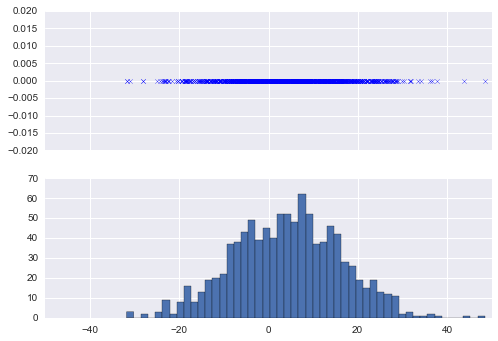

In [2]:
N = 1000
X1 = np.random.normal(4, 12, N)
f, axes = plt.subplots(nrows=2, sharex=True)
axes[0].set_xlim(-50, 50)
axes[0].scatter(X1, np.zeros(N), marker='x')
axes[1].hist(X1, bins=50)
plt.show()

To model this data as a normal distribution, we take the mean and the standard deviation from the sample we have.

In [3]:
sample_mean = X1.mean()
sample_sigma = X1.std()
print('Sample Mean:', sample_mean)
print('Sample Standard Deviation:', sample_sigma)

Sample Mean: 4.20741199577
Sample Standard Deviation: 12.1008227886


Our estimate for the distribution therefore looks like this:

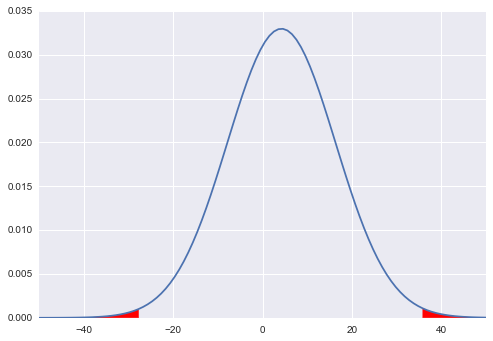

Lower Bound: -27.0127107989
Upper Bound: 35.4275347904


In [4]:
base = np.linspace(-50, 50, 100)
normal = [sp.stats.norm.pdf(x, sample_mean, sample_sigma) for x in base]
lower_bound = sample_mean - (2.58 * sample_sigma)
upper_bound = sample_mean + (2.58 * sample_sigma)
anomalous = np.logical_or(base < [lower_bound]*100, base > [upper_bound]*100)

plt.plot(base, normal)
plt.fill_between(base, normal, where=anomalous, color='red')
plt.xlim(-50, 50)
plt.show()
print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

Now we just have to decide on some 'epsilon' value, which dictates our probability threshold for anomalous events.  If we set epsilon to .01, we're saying that any draw for which there's a probability of 1% or less that it given the above distribution should be marked as anomalous.  These values are the upper and lower bounds for what we consider 'normal', and are represented in the graphs above by the area shaded in red.

Let's look at two sample draws to see if they're anomalous.

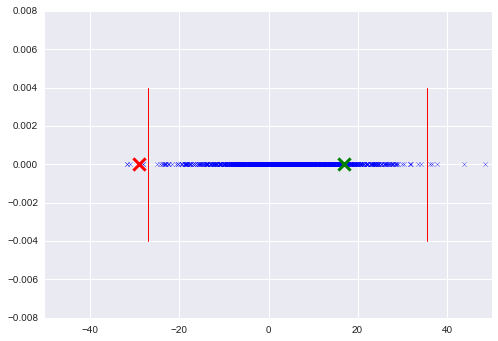

In [5]:
plt.scatter(X1, np.zeros(N), marker='x')
plt.xlim(-50, 50)
plt.scatter(-29, 0, marker='x', color='red', s=150, linewidths=3)
plt.scatter(17, 0, marker='x', color='green', s=150, linewidths=3)
plt.axvline(lower_bound, ymin=.25, ymax=.75, color='red', linewidth=1)
plt.axvline(upper_bound, ymin=.25, ymax=.75, color='red', linewidth=1)
plt.show()

Here we can see that the red draw exceeds the lower bound, and would therefore come up as anomalous, whereas the green draw falls within the normal range.

Note that we’re losing some uncertainty by doing it this way.  We’re using the sample mean and standard deviation directly as estimates for the population mean and standard deviation, but of course there is some uncertainty in those estimates.  This model has no mechanism for preserving that uncertainty; we get the same probability estimate for any given event regardless of how certain we are about our estimates for those parameters.

### Non-normally distributed single variable

In this section, we’ll look at a slightly more complicated case, in which we have observations with a single feature that are not normally distributed.  This will demonstrate two additional shortcomings of the standard approach to anomaly detection.  First, we’ll have to manually manipulate the data to ‘look’ normal.  Second, there is no simple way to encode pre-existing knowledge about the distributions into the model.

Imagine that our observations can only take on positive values, which is a common restriction. For simplicity, let's use the same observations we used earlier, but we'll simply drop all negative observations.

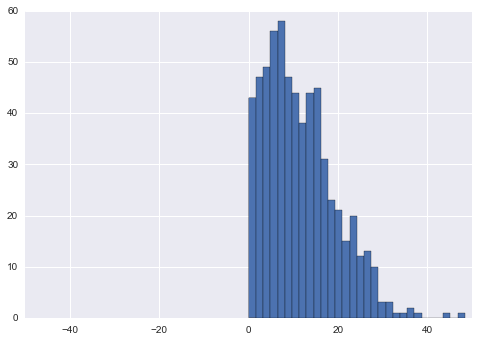

In [6]:
X2 = np.array([x for x in X1 if x > 0])
plt.hist(X2, bins=30)
plt.xlim(-50, 50)
plt.show()

Just looking at the data, it seems that it no longer makes sense to model these observations as normally distributed.  Let's see what happens if we do try to model this as a normal distribution:

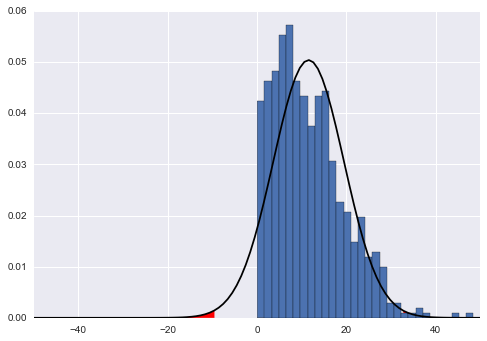

Lower Bound: -8.86419929781
Upper Bound: 31.9838968773


In [7]:
sample_mean = X2.mean()
sample_sigma = X2.std()
base = np.linspace(-50, 50, 100)
normal = [sp.stats.norm.pdf(x, sample_mean, sample_sigma) for x in base]
lower_bound = sample_mean - (2.58 * sample_sigma)
upper_bound = sample_mean + (2.58 * sample_sigma)
anomalous = np.logical_or(base < [lower_bound]*100, base > [upper_bound]*100)

plt.plot(base, normal, color='black')
plt.fill_between(base, normal, where=anomalous, color='red')
plt.hist(X2, bins=30, normed=True)
plt.xlim(-50, 50)
plt.show()
print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

Clearly this distribution does not fit our data!  Most obviously, it wouldn't declare an observation anomalous until it was less than ~ -8.9, while we already know that anything less than 0 is highly anomalous.  When we get into bayesian analysis and probabilistic programming we'll see how we can encode this prior knowledge into our models.

In the meanwhile, one common work around is to transform the observations until they look vaguely like they come from a normal distribution.  Common approaches for positive distributions include taking the logarithm of every observation, or raising it to a power less than 1.  With this data, it turns out that raising each observation to .55 produces something roughly normal.

Though this is common practice, especially in low-lift anomaly detection systems, eyeballing distribution transformations should make you suspicious.  It results in haphazard analysis and fuzzy statistical reasoning.  Again, probabilistic programming will give us the tools to make sure that all parameters we use in our model are calculated using legitimate statistical methods.

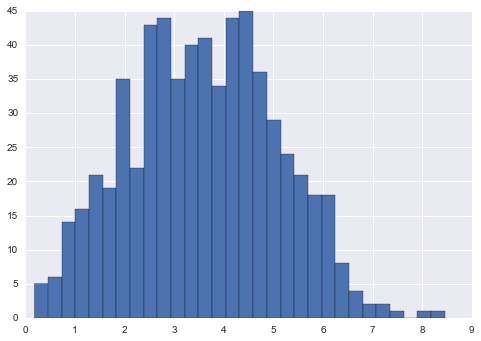

In [8]:
X3 = X2 ** .55
plt.hist(X3, bins=30)
plt.show()

We won't go through it here, but the next steps would be to run the same kind of analysis we ran on the data that actually was normally distributed, and to then check whether a new observation to the power .55 seemed anomalous.

### Multiple Independently Distributed Normal Variables

So far we've only been looking at observations with a single feature. We'll now expand our analysis to multiple variables. Initially we will assume that they are independently normal distributed. That is, that each feature is normally distributed, and there is no correlation between them.  Though this is still a simple example, this simple multi-dimensional case will set the stage for evaluating how the traditional methods of anomaly detection perform on more realistic data. 

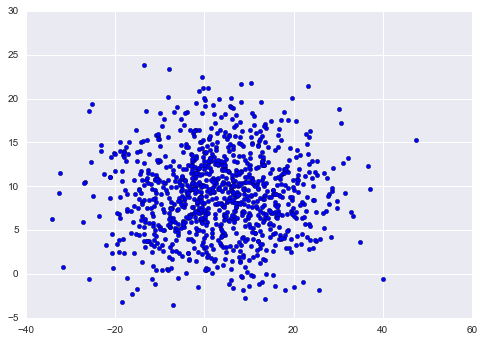

In [9]:
N = 1000
X1 = np.random.normal(4, 12, N)
X2 = np.random.normal(9, 5, N)
plt.scatter(X1, X2)
plt.show()

As before, we can estimate the means and standard deviations of the normal distributions through the samples.

In [10]:
x1_sample_mean = X1.mean()
x2_sample_mean = X2.mean()
x1_sample_sigma = X1.std()
x2_sample_sigma = X2.std()
print('Sample Mean 1:', x1_sample_mean)
print('Sample Mean 2:', x2_sample_mean)
print('Sample Standard Deviation 1:', x1_sample_sigma)
print('Sample Standard Deviation 2:', x2_sample_sigma)

Sample Mean 1: 3.07957128984
Sample Mean 2: 9.02005010207
Sample Standard Deviation 1: 12.1382458997
Sample Standard Deviation 2: 4.76924679208


As we would expect, these are not far from the actual values we used to generate the data.

Next, let's look at a heatmap of where we would expect to find observations given the joint probability distributions implied by these distributions.

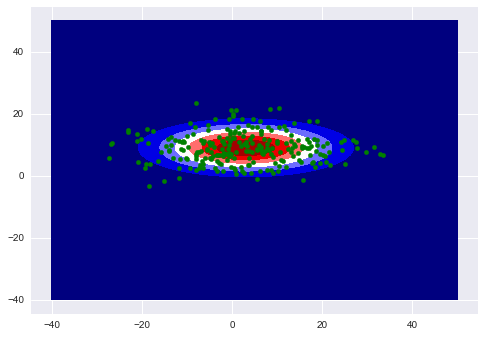

In [11]:
delta = 0.025
x1 = np.arange(-40, 50, delta)
x2 = np.arange(-40, 50, delta)
x, y = np.meshgrid(x1, x2)
z = plt.mlab.bivariate_normal(x, y, x1_sample_sigma, x2_sample_sigma, x1_sample_mean, x2_sample_mean)
plt.contourf(x, y, z, cmap='seismic')
thinned_points = np.array([n in np.random.choice(N, 300) for n in range(N)])
plt.scatter(X1[thinned_points], X2[thinned_points], color='green')
plt.show()

Because the two variables are independent, we get get this nice concentric circle shape, where as we move in towards the means, we're increasingly likely to draw an observation with those features. As we move away, we're less likely to see an observation with features at those values. We might, for instance, decide that anything in the dark-blue region is anomalous.

Note that because the distribution of the vertical feature has a smaller variance, the area of high probability is much thinner vertically than it is horizontally.

### Multiple Jointly Distributed Features

In this section, we’ll look at some slightly more realistic data.  We will try to use some of the methods we’ve built up to this point to tackle this more complex data.  

To build up more of an intuition of what’s going on, let's say that we're observing database transactions, and for each observation we record the latency and the average number of concurrent connections over the course of the transaction.

We expect these to be positively correlated - the database takes longer to process any given query as the number of active connections grows.  

We also know that neither of these features can be negative - you cannot have fewer than zero connections to the database, and you cannot finish a transaction before you start it (negative latency).

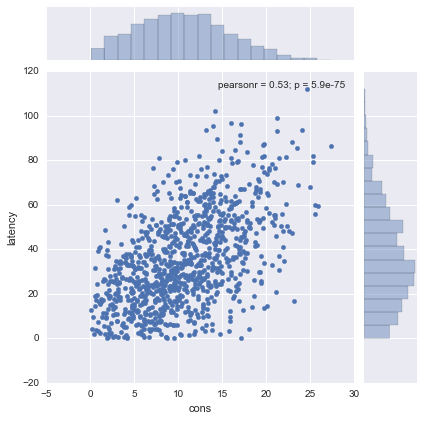

In [12]:
def positive_support_normal(mean, sigma, n):
    xs = np.random.normal(mean, sigma, n)
    for i, num in enumerate(xs):
        while num < 0:
            num = np.random.normal(mean[i], sigma)
        xs[i] = num
    return xs
    
N = 1000

mu_cons = 10
sigma_cons = 6
sigma_latency = 20
beta = 3

cons = positive_support_normal(np.array([mu_cons]*N), sigma_cons, N)
latency = positive_support_normal(beta * cons, sigma_latency, N)
ax = sns.jointplot('cons', 'latency', pd.DataFrame({'cons': cons, 'latency': latency}))

Now if we use our previous method - where we treat each feature as independently normally distributed - to think about the probability of finding observations with a particular combination of features, we'll see something like this:

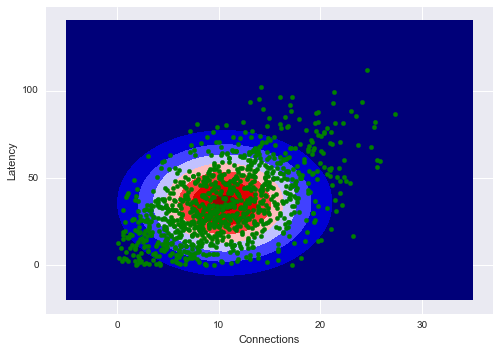

In [13]:
delta = 0.025
x1 = np.arange(-5, 35, delta)
x2 = np.arange(-20, 140, delta)
x, y = np.meshgrid(x1, x2)
z = plt.mlab.bivariate_normal(x, y, cons.std(), latency.std(), cons.mean(), latency.mean())
plt.contourf(x, y, z, cmap='seismic')
plt.scatter(cons, latency, color='green')
plt.ylabel('Latency')
plt.xlabel('Connections')
plt.show()

The problem is that we're missing something about the relationship between the two features.  We _know_ that latency depends on the number of concurrent connections, but it's difficult to account for that in our model.

There are a few ways to address this issue.  For example, we could engineer a new feature from the existing data that might capture some of the correlation between the two, and treat that as independently normally distributed as well. Alternatively, we could use the observed data to estimate the covariance relation between the two features and model and keep trying to model them as a multivariate normal distribution.

Any of these steps quickly get complicated and, more importantly, imprecise.  So far we've only explored relatively simple distributions with very small numbers of features.  Each feature needs to be  be transformed somehow to the normal.  We might need to build new features by hand to improve our models properties, and most often we'll assume that if features are correlated, they at least have joint normal distributions.

Assumptions about distributions are a good place to start, but we should be able to learn from the data in a more robust and systematic way than eyeballing the value of added features or distribution transformations.

That's exactly where Bayesian modeling and probabilistic programming come in.

### Bayesian modeling 

Bayesian modeling is a way of calculating the likelihood of some observation, given the data you've already seen.  It allows you to declare your statistical beliefs about what your data _should_ look like before you look at the data.  These beliefs are known as 'priors'.  You can declare one for each of the parameters you're interested in estimating. Bayesian modeling looks at these priors and the observed data, and calculates a distribution for each of those parameters.  These are known as 'posterior distributions'.  

Part of the benefit of probabilistic programming, relative to comparable Bayesian modeling in the past, is that you don't need to know anything about how that calculation happens.

### Probabilistic Programming

Roughly speaking, the steps involved in probabilistic programming are as follows:

1. Declare your prior beliefs about what the data looks like.
2. Feed in your data.
3. A sampling algorithm will return a posterior distribution for each of the parameters in your model.

Probabilistic programming languages enable you to state your priors beliefs and your model with elegant, statistical syntax.  

The more data you have to learn from, the less your prior beliefs matter, and generally the tighter the distributions you'll get for your model parameters.

There are several advantages here.  First, you get a formal way to encode your knowledge about the data into your model.  As we saw earlier, this is especially useful when you know that there is no chance at all of certain observations.

Second, there are no limitations on which distributions we can use to model our world, or on the hierarchical relations we claim they have.  Which  means, among other things, that and we don't have to estimate data manipulations to make things look right.

Third, we get to propagate our uncertainty.  For example, instead of simply estimating the mean of the population distribution as the sample mean, we estimate the population mean as a distribution itself, and the nature of this uncertainty will affect our final model of the data.

It's simpler than ever to build a complex model of the world.

### A Simple Example

The example below is constructed using the python interface to [Stan](http://mc-stan.org/), which is one of the most mature probabilistic programming language out there today.  

Stan is a compiled language.  In the code below, we store the Stan model as a python string.  The Stan model is then compiled and passed the data we define in the `data` named parameter to the `pystan.stan` function.

Here we can finally overcome a few of the difficulties we encountered earlier.  First, we can declare that neither variable can take on a negative value.  Second, we can create a simple hierarchical model that encodes our beliefs about the data.  In this case, we expect latency to depend on the number of concurrent connections, and we can declare that.  Finally, we can propagate our uncertainty throughout the model.

This is not a Stan tutorial, so we won't go into great detail on how to do this, but the Stan code below is commented so as to provide an intuition for how it all works.

The left column of graphs represent the posterior distributions of parameters.
The right column of graphs plot the samples drawn from those distributions.


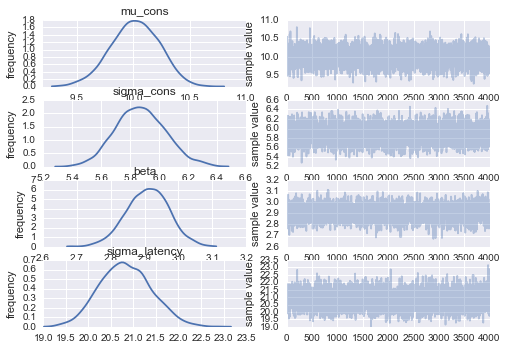

In [14]:
import pystan

model_code = """
    data {
        int<lower=0> N;             // number of observations
        vector<lower=0>[N] latency; // observed latency
        vector<lower=0>[N] cons;    // observed concurrent connections
        
        real latency_test;          // test for event probabilities
        real cons_test;             // test for event probabilities
    }

    parameters {
        real mu_cons;               // mean of concurrent connections
        real sigma_cons;            // sigma of concurrent connections
        real sigma_latency;         // sigma of latencies
        real beta;                  // linear coefficient for connections in latency
    }
    
    model {
        // declare some weak prior beliefs about our parameters
        mu_cons ~ normal(100, 100);
        sigma_cons ~ normal(100, 100);
        sigma_latency ~ normal(100, 100);
        beta ~ uniform(-100, 100);
    
        // both these distributions are truncated below at 0.0
        for (i in 1:N) {
            cons[i] ~ normal(mu_cons, sigma_cons) T[0.0,]; 
            latency[i] ~ normal(beta * cons[i], sigma_latency) T[0.0,]; // latency is linearly related to cons 
        }
    }
    
    generated quantities {
        real prob_cons;
        real prob_latency;
        real prob;

        prob_cons <- 2 * (.5 - abs(.5 - normal_cdf(cons_test, mu_cons, sigma_cons)));
        prob_latency <- 2 * (.5 - abs(.5 - normal_cdf(latency_test, beta * cons_test, sigma_latency)));
        prob <- prob_cons * prob_latency;
    }
"""

data = {
    'N': N,
    'latency': latency,
    'cons': cons,
    'latency_test': 3.,
    'cons_test': 3.,
}

fit = pystan.stan(model_code=model_code, data=data)
fit.plot(['mu_cons', 'sigma_cons', 'beta', 'sigma_latency'])
print('The left column of graphs represent the posterior distributions of parameters.')
print('The right column of graphs plot the samples drawn from those distributions.')
plt.show()

Stan will also provide summary statistics about each parameter in the model:

In [15]:
print(fit)

Inference for Stan model: anon_model_39252ec70065ee074bb53919d98789f1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_cons        10.02  6.5e-3   0.22   9.58   9.87  10.02  10.17  10.42   1091    1.0
sigma_cons      5.87  5.3e-3   0.17   5.54   5.75   5.87   5.99   6.24   1074    1.0
sigma_latency  20.83    0.02   0.58  19.75  20.42  20.81  21.21  21.99   1132    1.0
beta            2.91  1.9e-3   0.06   2.78   2.87   2.91   2.95   3.03   1088    1.0
prob_cons       0.23  7.3e-4   0.02   0.19   0.22   0.23   0.25   0.28   1007    1.0
prob_latency    0.78  3.2e-4   0.01   0.76   0.78   0.78   0.79    0.8   1056    1.0
prob            0.18  5.8e-4   0.02   0.15   0.17   0.18   0.19   0.22   1002    1.0
lp__           -5451    0.05   1.41  -5454  -5452  -5451  -5450  -5449    830    1.0

Samples were drawn using NUTS(diag_e) at Fri 

Not surprisingly, Stan effectively recovers the parameters we used to generate the data.  As you can see, the output is not simply a point estimate for each parameter.  The fit object stores a distribution for each of the parameters, so that your uncertainty about them can be propagated through to the end.

In this case we’re checking whether an observation with 3 concurrent connections and a latency measure of 3 is anomalous.  The model returns ~20% probability of seeing a more extreme value, so we conclude that it is not anomalous.  We can see that we even get a distribution over the probability of seeing the event in question, not just a point estimate.  This can be invaluable in anomaly detection.

For the sake of comparison, let's graph a contour plot similar to the one above.  In this case we'll simply calculate point estimates of the probability at each x,y coordinate.

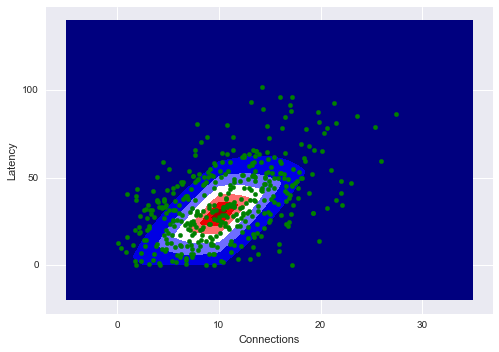

In [16]:
summary = fit.summary()
means = dict(zip(summary['summary_rownames'], [s[0] for s in summary['summary']]))

delta = .1
x1 = np.arange(-5, 35, delta)
x2 = np.arange(-20, 140, delta)
x, y = np.meshgrid(x1, x2)

z = np.zeros((x.shape[0], y.shape[1]))

def extreme(val, mu, sig):
    return 2 * (.5 - abs(.5 - sp.stats.norm.cdf(val, mu, sig)))

for i, con in enumerate(x[0]):
    for j, lat in enumerate(y[:,0]):
        con_prob = extreme(con, means['mu_cons'], means['sigma_cons']) 
        lat_prob = extreme(lat, means['beta'] * con, means['sigma_latency'])
        z[j, i] = con_prob * lat_prob if con >= 0 and lat >= 0 else 0

plt.contourf(x, y, z, cmap='seismic')
thinned_points = np.array([n in np.random.choice(N, 500) for n in range(N)])
plt.scatter(cons[thinned_points], latency[thinned_points], color='green')
plt.ylabel('Latency')
plt.xlabel('Connections')
plt.show()

Here we can see that our model of the probability of a particular observation captures the relationship between features in our data.

### Conclusion

In the probabilistic programming code above, we do some relatively advanced modeling.  We are able to declare our prior beliefs about the distributions model, truncate distributions at arbitrary points, and treat our observed features hierarchically.  Stan takes our declarations, which are written in simple, statistical syntax, and runs a sampling algorithm to find the posterior distributions of our models.  Using these posterior distributions, we can evaluate the likelihood of an observation given our data (and our priors).  

Hopefully this hints at how probabilistic programming allows for a simple way to create easily customizable models for use in anomaly detection.  Powerful anomaly detection, though, is only the beginning of what you can do with probabilistic programming.